In [1]:
import ROOT, os, sys, glob
import numpy as np
from math import *
from matplotlib import pyplot as plt
from ROOT import kBlack, kBlue, kRed

ROOT.EnableImplicitMT(4);

Welcome to JupyROOT 6.28/00


In [2]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.1.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M3p5_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M40_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M4_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1

In [3]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.0.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_BsToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_JPsiToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root']

In [4]:
def Efficiency_plotter(file_name):
    rdf = ROOT.RDataFrame("Events",f"/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/{file_name}")
    def makeDimuonPairs(name, rdf):
        ## define 4-vectors in cartesian coordinates, for easier 
        rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
        ## make indices of all the pairs
        rdf = rdf.Define(f"{name}DiMu_indices", f"""
            ROOT::VecOps::RVec<std::pair<int,int>> ret; 
            for (int i = 0, n = n{name}Mu; i < n; ++i) 
                for (int i2 = i+1; i2 < n; ++i2) 
                    ret.emplace_back(i,i2);
            return ret;""")

        #Let us impose a selection criteria here


        ## Make the number of dimuons, for convenience later
        rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
        ## compute the mass, charge
        rdf = rdf.Define(f"{name}DiMu_mass", f"""
            ROOT::RVecF ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_charge", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
            return ret;""")



        rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
            ROOT::RVecI ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_eta", f"""
            ROOT::RVecF ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::max(abs({name}Mu_eta[pair.first]),abs({name}Mu_eta[pair.second])));
            return ret;""")
        
        rdf=rdf.Define(f"{name}DiMu_dz",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
            return ret;""")
        #min pT of thw two
        rdf = rdf.Define(f"{name}Mu_minPT",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
            return ret;""") #

        return rdf;
    
    entries_no_pair = rdf.Count().GetValue()
    
####################################################################################################################################################################    
    def makeTk_DiMuonPairs(rdf):
    
        #this is to defne DiMuon pairs for different properties
        rdf = rdf.Define(f"TkDiMu_hwIsoSum", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSum[pair.first],TkMu_hwIsoSum[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwIsoSumAp", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSumAp[pair.first],TkMu_hwIsoSumAp[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwQual", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::min(TkMu_hwQual[pair.first],TkMu_hwQual[pair.second]));
            return ret;""")

        return rdf;
    rdf_Tkdimu_one = makeDimuonPairs("Tk",rdf) 
    rdf_Tkdimu = makeTk_DiMuonPairs(rdf_Tkdimu_one)
    h_TkDiMu_mass = rdf_Tkdimu.Histo1D(("","",50,20,30),"TkDiMu_mass")
    
    entries_Tk_pair = rdf_Tkdimu.Count().GetValue()
    
####################################################################################################################################################################
    
    rdf_genDiMu = makeDimuonPairs("Gen",rdf_Tkdimu)
    
    entries_gen_pair = rdf_genDiMu.Count().GetValue()
    
    def select_ind(name, rdf):
    
        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>2.) && (TkDiMu_hwQual>75) && ({name}DiMu_eta <= 2) && (TkDiMu_hwIsoSumAp<=1.5) && (TkDiMu_hwIsoSum<=1.5)")                    
        rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")
        rdf = rdf.Define(f"GoodTkDiMu_hwQual",f"TkDiMu_hwQual[{name}DiMu_good]")
        rdf = rdf.Define(f"GoodTkDiMu_hwIsoSum",f"TkDiMu_hwIsoSum[{name}DiMu_good]")
        rdf = rdf.Define(f"GoodTkDiMu_hwIsoSumAp",f"TkDiMu_hwIsoSumAp[{name}DiMu_good]")
        #rdf = rdf.Define(f"TkDiMu_selEta",f"TkDiMu_eta[{name}DiMu_good]")

        #rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
        return rdf;

    #rdf_selFeat = select_ind("Gen",rdf_idxSel)
    rdf_Tk_selFeat = select_ind("Tk", rdf_Tkdimu)
    h_TkDiMu_selMass = rdf_Tk_selFeat.Histo1D(("","",50,20,30),"TkDiMu_selMass")
    
####################################################################################################################################################################    
    
    def indexSelect(rdf):
        rdf = rdf.Define("TkDiMu_indMatch","(TkDiMu_minIdx!=-1)" )
        rdf = rdf.Define(f"IdxDiMu_indices", f"TkDiMu_indices[TkDiMu_indMatch]")
        rdf = rdf.Filter(f"Sum(TkDiMu_indMatch)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_Idx",f"IdxDiMu_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxMass",f"TkDiMu_mass[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxCharge",f"TkDiMu_charge[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_Idxdz",f"TkDiMu_dz[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxMinPt",f"TkMu_minPT[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSum",f"TkDiMu_hwIsoSum[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSumAp",f"TkDiMu_hwIsoSumAp[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwQual",f"TkDiMu_hwQual[TkDiMu_indMatch]")
        rdf = rdf.Define("TkDiMu_IdxEta","TkDiMu_eta[TkDiMu_indMatch]")
        return rdf;

    rdf_idxSel = indexSelect(rdf_Tk_selFeat)
    
    entries_idx_pair = rdf_idxSel.Count().GetValue()
    
####################################################################################################################################################################
    
    hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,20,30), "TkDiMu_IdxMass")

   
    
    
    def select_idx_tk(rdf):

        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"TkDiMu_Idx_good", f"(TkDiMu_IdxCharge <0.1 && TkDiMu_IdxCharge > -0.1) &&(TkDiMu_Idxdz <1 && (TkDiMu_Idxdz > -1))&&(TkDiMu_IdxMinPt > 2.) && (TkDiMu_IdxhwQual>75) && (TkDiMu_IdxEta <= 2) && (TkDiMu_IdxhwIsoSum<=1.5) && (TkDiMu_IdxhwIsoSumAp<=1.5)")                    
        rdf = rdf.Define(f"TkDiMu_sel_Idx_indices", f"IdxDiMu_indices[TkDiMu_Idx_good]")
        rdf = rdf.Filter(f"Sum(TkDiMu_Idx_good)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_IdxSel",f"TkDiMu_sel_Idx_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxselMass",f"TkDiMu_IdxMass[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselCharge",f"TkDiMu_IdxCharge[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_Idxseldz",f"TkDiMu_Idxdz[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselMinPt",f"TkDiMu_IdxMinPt[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwQual",f"TkDiMu_IdxhwQual[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSum",f"TkDiMu_IdxhwIsoSum[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSumAp",f"TkDiMu_IdxhwIsoSumAp[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"GoodTkDiMu_minIdx",f"TkDiMu_minIdx[TkDiMu_Idx_good]")

        return rdf;
    rdf_Tk_IdxselFeat = select_idx_tk(rdf_idxSel)
    
    #rdf_Tk_IdxselFeat = select_idx_tk(rdf_Tk_selFeat)
    
    entries_selIdx_pair = rdf_Tk_IdxselFeat.Count().GetValue()
    
####################################################################################################################################################################    
    hGoodIdxTkPairMass = rdf_Tk_IdxselFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,20,30), "TkDiMu_IdxselMass")
    
    h1 = hGoodIdxTkPairMass.GetPtr()
    h1.SetLineColor(kBlue+1)
    h1.SetLineWidth(2)
    h1.SetMaximum(4000)
    h2 = hIdxTkPairMass.GetPtr()
    h2.SetLineColor(kRed)
    h2.SetLineWidth(2)
    h2.SetMaximum(4000)
    
    def createRatio(h1, h2):
        h3 = h1.Clone("h3")
        h3.SetLineColor(kBlack)
        h3.SetMarkerStyle(21)
        h3.SetTitle("")
        h3.SetMinimum(0)
        h3.SetMaximum(1.2)
        # Set up plot for markers and errors
        h3.Sumw2() #what is this used for (removal of zeros is the rough idea I have)
        h3.SetStats(0)
        h3.Divide(h2)

    #     # Adjust y-axis settings
        y = h3.GetYaxis()
        y.SetTitle("ratio h1/h2 ")
        y.SetNdivisions(505)
        y.SetTitleSize(20)
        y.SetTitleFont(43)
        y.SetTitleOffset(1.55)
        y.SetLabelFont(43)
        y.SetLabelSize(15)

    #     # Adjust x-axis settings
        x = h3.GetXaxis()
        x.SetTitleSize(20)
        x.SetTitleFont(43)
        x.SetTitleOffset(4.0)
        x.SetLabelFont(43)
        x.SetLabelSize(15)

        return h3;
    
    
    h3 = createRatio(h1, h2)
    
    e1 = entries_selIdx_pair/entries_no_pair
    e2 = entries_selIdx_pair/entries_idx_pair
    
    
    return dict(h1=h1, h2=h2, h3=h3, e1=e1, e2=e2, entries_idx_pair=entries_idx_pair,entries_Tk_pair=entries_Tk_pair, h_TkDiMu_mass=h_TkDiMu_mass, h_TkDiMu_selMass=h_TkDiMu_selMass);

In [5]:
#for single neutrino background you only need h_TkDiMu_mass, h_TkDiMu_selMass
data_bg = Efficiency_plotter("l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root")

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


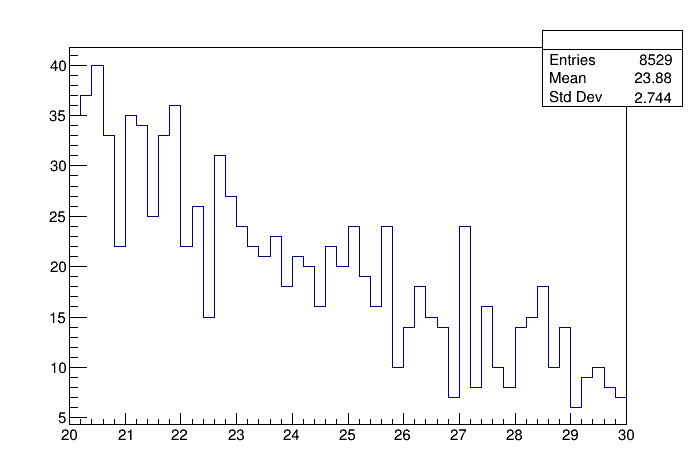

In [6]:
c = ROOT.TCanvas()
c.cd()
data_bg['h_TkDiMu_selMass'].Draw()
c.Draw()

In [8]:
# m = "3"
# data_{m}=20
# print(data_3)

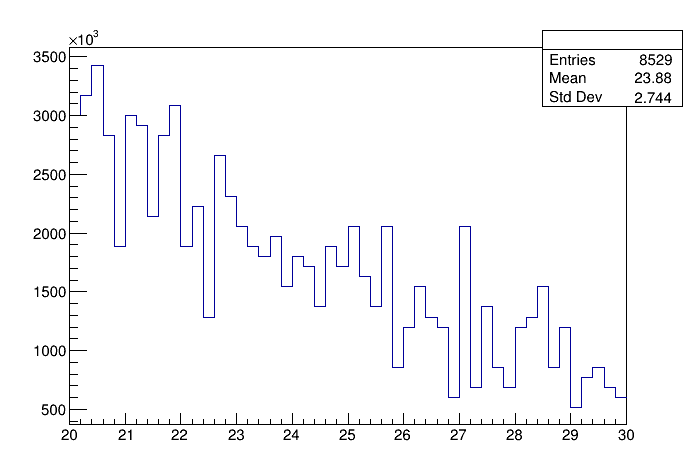

In [43]:
#scaling for single neutrino background/ signal where Freq = cross section and T = L
def dY_Number(h, Freq, T, entries):
    h_final = h.Clone()
    h_final.Scale((Freq*T)/entries)
    return h_final;

h5_bg = dY_Number(data_bg['h_TkDiMu_selMass'].GetPtr(), (21.3*(10**6)), 400,data_bg['entries_Tk_pair']) #for single neutrino
c = ROOT.TCanvas()
c.cd()
h5_bg.Draw("hist")
c.Draw()

In [37]:
i=h5_bg.GetXaxis().FindBin(25)
N_b_by_m=(h5_bg.GetBinContent(i)/h5_bg.GetXaxis().GetBinWidth(i))
print(N_b_by_m)

10289855.072463766


In [38]:
#h.Integral(0, h.GetNbinsX()+1)

data_sig = Efficiency_plotter("l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root")

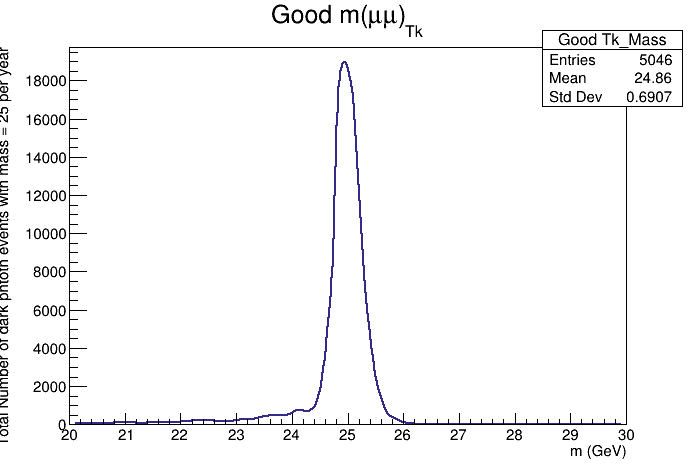

In [39]:
h4_sig = data_sig['h1'].Clone()
h4_sig.Scale((((21.53*(10**3))*(3e-6/(0.02**2)))*400)/data_sig['entries_idx_pair'])
y = h4_sig.GetYaxis()
y.SetTitle("Total Number of dark phtotn events with mass = 25 per year")
c1 = ROOT.TCanvas()
c1.cd()
h4_sig.Draw("hist c plc")
c1.Draw()

Standard Deviation = 0.2407181608459536
 FCN=484.941 FROM MIGRAD    STATUS=CONVERGED     274 CALLS         275 TOTAL
                     EDM=1.30857e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.84347e+04   3.81505e+02   2.97058e+00  -5.83250e-07
   2  p1           2.50114e+01   3.64303e-03   3.88268e-05  -1.34143e-01
   3  p2           2.40718e-01   3.43557e-03   2.66356e-05  -1.21170e-02


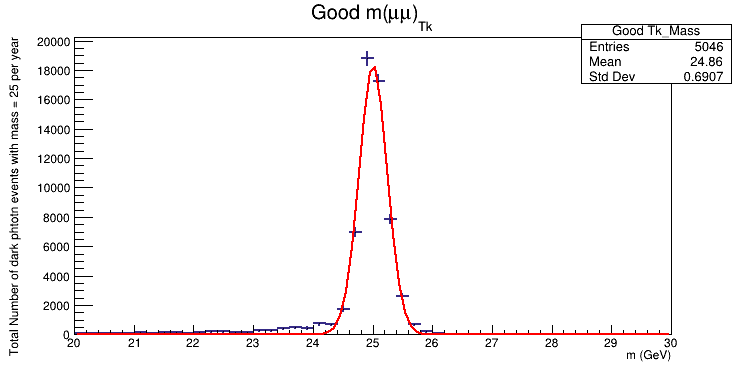

In [40]:
h5 = h4_sig.Clone()
# h4.Copy(h5)
# data = h5.GetValue()
c = ROOT.TCanvas("c","c",750,400)

fit = ROOT.TF1("fit", "[0]*exp(-0.5*((x-[1])/[2])^2)", 20, 30)
fit.SetParameter(1, 24.68)
fit.SetParameter(2, 0.69071)
# for i in range(3):
#     fit.SetParameter(i, fit.GetParameter(i))

fit.SetLineColor(2)
fit.SetLineStyle(1)
fit.SetLineWidth(2)
h5.Draw()
h5.Fit("fit", "0", "", 20, 30)
std = fit.GetParameter(2)
fit.Draw("SAME")
c.Draw()
print(f"Standard Deviation = {std}")

In [41]:
N_s = h4_sig.Integral(0,h4_sig.GetNbinsX()+1)
print(N_s)

62979.930434782626


In [42]:
#Calculating signal strength
strength = N_s/((N_b_by_m*(2*std))**0.5)
print(strength)

28.296200326909315
